In [6]:
import pandas as pd
import numpy as np
import re
import ast
import sys
sys.path.append("..")   # từ notebooks lên project

from src.features import build_features
from sklearn.model_selection import train_test_split

In [8]:
df = pd.read_csv("../data/processed/one_event_sequences.csv")
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)
X_train, tfidf_vec = build_features(X_train, mode="train")
X_test, _ = build_features(X_test, mode="infer", tfidf_vectorizers=tfidf_vec)

In [9]:

from sklearn.ensemble import IsolationForest

model = IsolationForest(
    n_estimators=1000,
    contamination="auto",
    max_samples="auto",
    random_state=42
)

model.fit(X_train)


,n_estimators,1000
,max_samples,'auto'
,contamination,'auto'
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


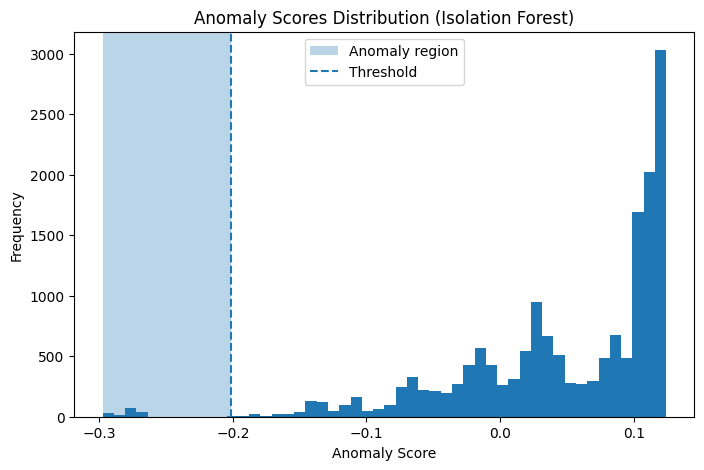

In [10]:
test_result = pd.DataFrame({
    "score_sample": model.score_samples(X_test),
    "decision_function": model.decision_function(X_test)
})


scores = test_result["decision_function"].values
threshold = np.percentile(scores, 1)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.hist(scores, bins=50)

plt.axvspan(
    scores.min(),
    threshold,
    alpha=0.3,
    label="Anomaly region"
)

plt.axvline(
    threshold,
    linestyle="--",
    label="Threshold"
)

plt.title("Anomaly Scores Distribution (Isolation Forest)")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

| Hàm                 | Ý nghĩa                          |
| ------------------- | -------------------------------- |
| `decision_function` | Cao = normal, **Thấp = anomaly** |
| `score_samples`     | Cao = normal, **Thấp = anomaly** |

In [11]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

/mnt/disk1/aiotlab/envs/unsloth/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


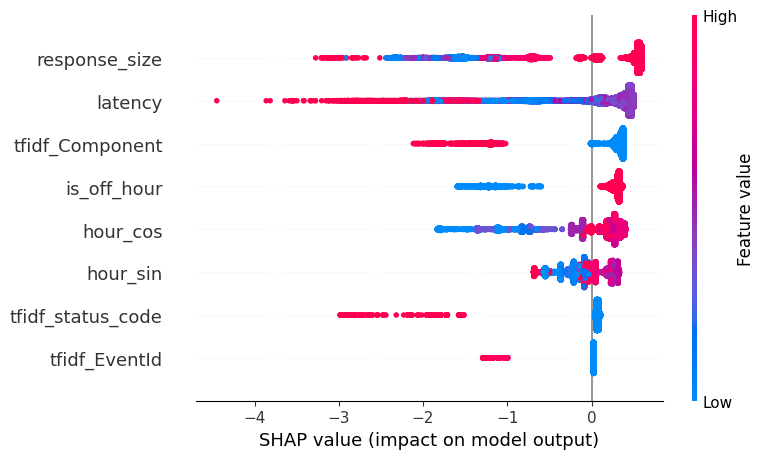

In [12]:
shap.summary_plot(shap_values, X_test)

In [13]:

def explain_anomaly(i, shap_values, X):
    contrib = shap_values[i]
    top = np.argsort(np.abs(contrib))[:][::-1]

    explanation = []
    for j in top:
        explanation.append(
            f"{X.columns[j]}={X.iloc[i, j]:2f} (impact={contrib[j]:.3f})"
        )
    return explanation

explain_anomaly(4, shap_values, X_test)

['response_size=129.000000 (impact=-1.765)',
 'tfidf_Component=2.993882 (impact=-1.382)',
 'is_off_hour=1.000000 (impact=0.277)',
 'hour_sin=0.258819 (impact=0.236)',
 'latency=0.255516 (impact=0.142)',
 'hour_cos=0.965926 (impact=0.131)',
 'tfidf_status_code=1.023106 (impact=0.100)',
 'tfidf_EventId=1.010832 (impact=0.028)']